# Import Libraries

Zuerst binden wir wie immer die Benutzen Bibliotheken ein.

In [1]:
from netgen.geom2d import *
import scipy
import scipy.sparse.linalg

from scipy.stats import unitary_group
from ngsolve import *
from ngsolve.webgui import Draw
import numpy as np
from scipy.linalg import block_diag
import time


import matplotlib.pyplot as plt

Unterliegender Block wird noch in eigene Library gepackt

In [21]:
def gen_rand_mat(eig, compl = False):
    n = eig.shape[0]
    if compl:
        B = np.random.rand(n,n) + np.random.rand(n,n)*compl*1j
    else:
        B = np.random.rand(n,n)
    return np.linalg.inv(B)@np.diag(eig)@B



def error(eig_1, eig_2):
    eig_1 = np.sort(eig_1)
    eig_2 = np.sort(eig_2)
    eig_2 = eig_2[:len(eig_1)]
    return np.linalg.norm(eig_1 - eig_2, np.inf)

def runtime(f, A):
    start = time.time()
    S = f(A)
    end = time.time()
    return end - start

def runtime_error(f, A, eigv, k = 0, l = 0):
    if k == 0:
        l, S, count = f(A)
        S = error(S, eigv)
    else:
        l, S, count = f(lambda x: A@x, k, l)[1]
        S = error(S, eigv)
    return count, S


def generate_rand_eigvals(n):
    return np.sort(5000*np.random.rand(n)-25)


def QR_hesse(A,tol=1e-10):
    n = A.shape[1]
    count = 0
    for i in range(n-1,0,-1):
        while abs(A[i,i-1]) > tol*(abs(A[i-1,i-1])+abs(A[i,i])):
            w = np.linalg.eigvals(A[i-1:i+1,i-1:i+1])
            if abs(w[0] - A[i,i]) < abs(w[1] - A[i,i]):
                rho = w[0]
            else:
                rho = w[1]
            Q,R = QR_decomp_hesse(A-rho*np.identity(n))
            A = R@Q + rho*np.identity(n)
            count += 1
        A[i,:i-n] = 0
    return A, sorted(np.diag(A)), count

def gen_hess(n, compl = False):
    if compl:
        a = np.random.rand(n) + np.random.rand(n)*1j
        b = np.random.rand(n-1) + np.random.rand(n-1)*1j
        c = np.random.rand(n-1) + np.random.rand(n-1)*1j
        return np.diag(b, -1) + np.diag(a,0) + np.diag(c, 1)
    else:
        A = np.zeros((n,n))
        a = np.random.rand(n)*50
        for j in range(n-1):
            b = np.random.rand(n-j-1)*50
            A = A + np.diag(b,j+1)
        return np.diag(np.random.rand(n-1)*50, -1) + A
    
def gen_hermite(eig, compl = False):
    n = eig.shape[0]
    B = unitary_group.rvs(n)
    return B.T.conj()@np.diag(eig)@B


def err(A,B,k=0):
    if k == 0:
        k = len(A)
    print(np.linalg.norm(np.array(A[:k])-np.array(B[:k]), ord = 1))
    
def plot_err(A,B,k=0):
    if k == 0:
        k = len(A)
    return np.linalg.norm(np.array(A[:k])-np.array(B[:k]), ord = 1)

def plot_err_1(A,B,k):
    return abs(np.array(A[k])-np.array(B[k]))

def selective_error(eig_1, eig_2, k = 1):
    n_1 = len(eig_1)
    n_2 = len(eig_2)
    error_1 = np.linalg.norm(eig_1[:k] - eig_2[:k])
    error_2 = np.linalg.norm(eig_1[:n_1-k:-1] - eig_2[:n_2-k:-1])
    return error_1 + error_2

# Implemented QR-Algorithm

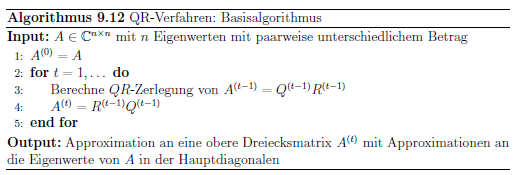


Diese simple Version ist schnell implementiert. Zur Fehler- und Laufzeittestung kommen wir am Ende des Abschnitts.

In [22]:
def QR_simple(A,tol = 1e-6):
    n = A.shape[1]
    count = 0
    for i in range(n-1,0,-1):                         #i durchläuft {1,...,n} rückwärts 
        while abs(A[i,i-1]) > tol:                    #in der Zeile ist immer labmda_i/lambda_{i-1} am größten
            Q,R = np.linalg.qr(A)                     #QR-Zerlegung der  Matrix
            A = R@Q                                   #RQ
            count +=1
        A[i,:i-n] = 0                                 #Die Zeile wird bis zur Diagonale auf 0 gesetzt um sich aufschaukelnde Fehler zu vermeiden
    return A, sorted(np.diag(A)), count

In [23]:
def QR_simple(A,tol = 1e-6):  #Toleranz wird auf Standardwert gesetzt, falls im Aufruf nicht anders angegeben
    n = A.shape[1]
    count = 0
    while max([abs(A[i,i-1]) for i in range(1,n)]) > tol:   #Abbruchbedingung, in dieser Implementation auch Aufwändig
        Q,R = np.linalg.qr(A)  #Für die QR-Zerlegung wurde eine Funktion aus dem Numpy-Linalg Paket verwendet
        A = R@Q                #Der wesentliche Schritt
        count +=1              
    return A, sorted(np.diag(A)), count

Hier Algorithmus Header Einfügen

In [24]:
def QR_shift(A,tol=1e-10):
    n = A.shape[1]                                    #Dimension wird gespeichert
    count = 0
    for i in range(n-1,0,-1):                         #i durchläuft {1,...,n} rückwärts 
        while abs(A[i,i-1]) > tol:                    #in der Zeile ist immer labmda_i/lambda_{i-1} am größten
            rho = A[i,i]                              #Der Shift-Parameter
            Q,R = np.linalg.qr(A-rho*np.identity(n))  #QR-Zerlegung der geshifteten Matrix
            A = R@Q + rho*np.identity(n)              #RQ + Rückshift
            count +=1
        A[i,:i-n] = 0                                 #Die Zeile wird bis zur Diagonale auf 0 gesetzt um sich aufschaukelnde Fehler zu vermeiden
    return A, sorted(np.diag(A)), count

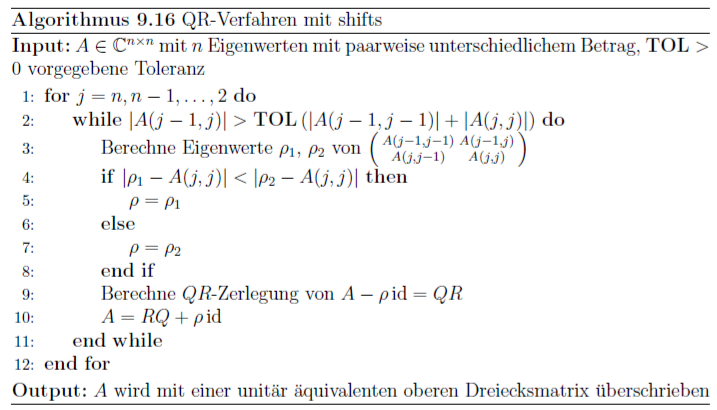

Die effizienteste Wahl des Shifts

In [25]:
def QR_shift2(A,tol=1e-14):
    n = A.shape[1]                                                #Dimension wird gespeichert
    count = 0
    for i in range(n-1,0,-1):                                     #i durchläuft {1,...,n} rückwärts
        while abs(A[i,i-1]) > tol*(abs(A[i-1,i-1])+abs(A[i,i])):  #Hier ein kleiner Fehler im Skript
            w = np.linalg.eigvals(A[i-1:i+1,i-1:i+1])             #Eigenwerte werden berechnet
            if abs(w[0] - A[i,i]) < abs(w[1] - A[i,i]):
                rho = w[0]
            else:
                rho = w[1]
            Q,R = np.linalg.qr(A-rho*np.identity(n))
            A = R@Q + rho*np.identity(n)
            count += 1
        A[i,:i-n] = 0
    return A, sorted(np.diag(A)), count

In [26]:
n_arr = [10*i for i in range(1,9)]                                 #Dimension des Problems

k = len(n_arr)
eigv_array = []
for i in range(k):
    eigv_array.append(np.sort(5000*np.random.rand(n_arr[i])-250)) #Eigenwerte werden zufällig generiert

In [27]:
mat_array = []

for i in range(k):
    mat_array.append(gen_rand_mat(eigv_array[i]))

In [28]:
time_1 = [0]*k
time_2 = [0]*k
time_3 = [0]*k

error_1 = [0]*k
error_2 = [0]*k
error_3 = [0]*k
for i in range(k):
    #time_1[i], error_1[i] = runtime_error(QR_simple, mat_array[i], eigv_array[i])
    time_2[i], error_2[i] = runtime_error(QR_shift, mat_array[i], eigv_array[i])
    time_3[i], error_3[i] = runtime_error(QR_shift2, mat_array[i], eigv_array[i])

C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  after removing the cwd from sys.path.


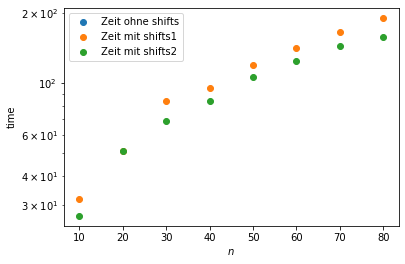

In [29]:
#%matplotlib notebook

plt.semilogy(n_arr, time_1, 'o', label = "Zeit ohne shifts")
plt.semilogy(n_arr, time_2, 'o', label = "Zeit mit shifts1")
plt.semilogy(n_arr, time_3, 'o', label = "Zeit mit shifts2")

plt.ylabel("time")
plt.xlabel("$n$")
plt.legend()
plt.show()

C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  after removing the cwd from sys.path.


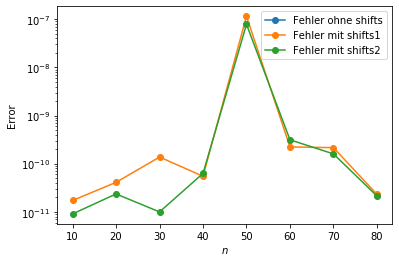

In [30]:
#%matplotlib notebook

plt.semilogy(n_arr, error_1, '-o', label = "Fehler ohne shifts")
plt.semilogy(n_arr, error_2, '-o', label = "Fehler mit shifts1")
plt.semilogy(n_arr, error_3, '-o', label = "Fehler mit shifts2")

plt.ylabel("Error")
plt.xlabel("$n$")
plt.legend()
plt.show()

## Special-Case: QR-Algorithm applied to a Hessian-Matrix

Hier können wir Givens-Rotation verwenden um die QR-Zerlegung durchzufühern und einen speed-up zu bekommen.

In [31]:
def QR_decomp_hesse(A):
    n = A.shape[0]
    Q = np.eye(n,n)

    for i in range(0,n-1):
        if abs(A[i,i]) >= abs(A[i+1,i]):                     #Überprüfen der Bedingung
            t = A[i+1,i]/abs(A[i,i])                         #Berechnung von t
            root = (1+abs(t)**2)**(1/2)                      #Ausdruck in der Wurzel
            c = A[i,i]/(abs(A[i,i])*root)                    #Berechnung von c
            s = t/root                                       #Berechnung von s
        else:
            t = A[i,i]/abs(A[i+1,i])                         #Berechnung von t
            root = (1+abs(t)**2)**(1/2)                      #Ausdruck in der Wurzel
            s = A[i+1,i]/(abs(A[i+1,i])*root)                #Berechnung von s
            c = t/root                                       #Berechnung von c
            
        #M = np.array([[c.conj(), s.conj()], [-s, c]])        #Erstellen der 2x2 Matrix
        #G = block_diag(np.eye(i,i), M, np.eye(n-i-2, n-i-2)) #Erstellen der vollen Matrix mit dem 2x2 Block innerhalb
        #Q = G@Q                                              #Multiplikation mit vorhergegangenen Givens-Rotationen
        for j in range(i, n):                                #Anwenden der Givens-Rotation, Änderungen nur in den Zeilen i, i+1
            temp_1 = A[i,j]                                  #temp um Wert für Berechnung zwischenzuspeichern
            A[i,j] = c.conj()*temp_1 + s.conj()*A[i+1,j]     #Neuer Eintrag (a_i, a_j) wird berechnet
            A[i+1,j] = -s*temp_1 + c*A[i+1,j]                #Neuer Eintrag (a_{i+1}, a_j) wird berechnet
        for j in range(n):
            temp_2 = Q[i,j]                                  
            Q[i,j] = c.conj()*temp_2 + s.conj()*Q[i+1,j]     
            Q[i+1,j] = -s*temp_1 + c*Q[i+1,j]
    return Q.T.conj(), A

Wir können nun auch Vergleichen.

In [32]:
n_arr_1 = [10*i for i in range(1,30)]       #Dimension des Problems

k = len(n_arr_1)
    
mat_array_1 = []

for i in range(k):
    mat_array_1.append(gen_hess(n_arr_1[i])) #Hesseberg-Matrizen der Dimension n werden erstellt

In [33]:
time_hesse = [0]*k
time_shift = [0]*k

for i in range(k):
    time_hesse[i] = runtime(QR_hesse, mat_array_1[i])
    time_shift[i] = runtime(QR_shift2, mat_array_1[i])

C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in matmul
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in matmul
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part


KeyboardInterrupt: 

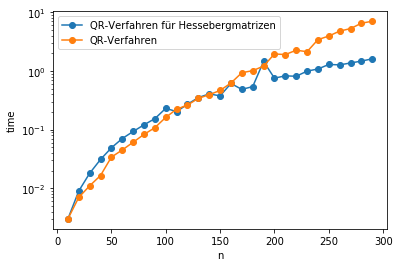

In [15]:
#%matplotlib notebook

plt.semilogy(n_arr_1, time_hesse, '-o', label = "QR-Verfahren für Hessebergmatrizen")
plt.semilogy(n_arr_1, time_shift, '-o', label = "QR-Verfahren")

plt.xlabel("n")
plt.ylabel("time")
plt.legend()
plt.show()

Wie man erkennt ist der Vorimplementierte QR-Algorithmus wohl immer noch effizienter.

QR an nicht-Hesseberg im Vergleich zu QR-Hesse an Hesseberg.


## Lanczos-Algorithm

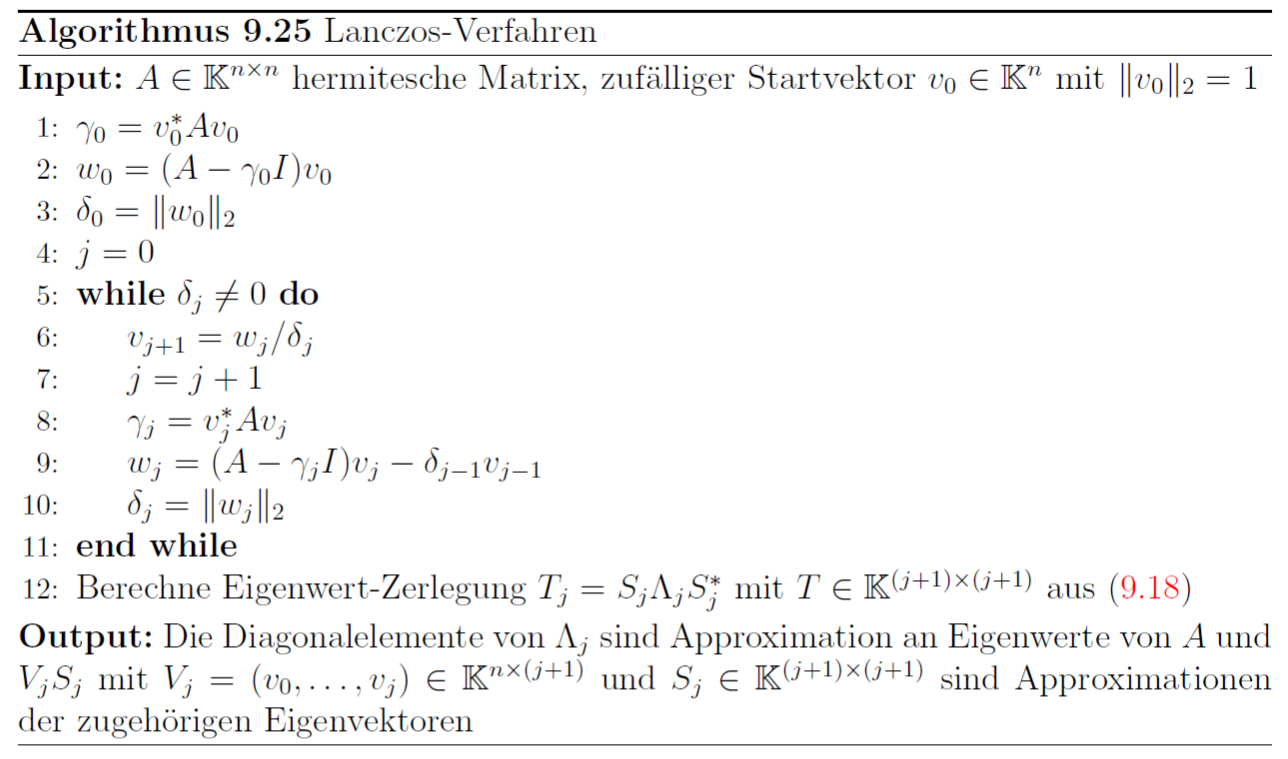

In [34]:
def lanczos(A,k = 0):                                         #k sei die Anzahl der zu berechnenden Eigenwerte
    n = A.shape[1]
    if k == 0:                                                #Wird keine Anzahl angegeben werden alle berechnet
        k = n
        
    v0 = np.random.rand(n)                                    #Randomisierter Startvektor wird gewählt
    v = [v0/np.linalg.norm(v0)]                               #Normieren sowie Listenerstellung
    gam = [v[0].T.conj()@A@v[0]]                              #Berechnung von gamma und Listenerstellung
    w = (A - gam[0]*np.identity(n))@v[0]                      #Berechnung des Vektors w
    delta = [np.linalg.norm(w)]                               #Zugehörige Norm sowie Listenerstellung
    i = 0
    while delta[i] > 1e-10 and i < k-1:                       #Sobald delta zu 0 wird haben wir unsere ONB aus Eigenvektoren
        v.append(w/delta[i])                                  #Liste der v wird erweitert
        i +=1
        gam.append(v[i].T.conj()@A@v[i])
        w = (A - gam[i]*np.identity(n))@v[i] - delta[i-1]*v[i-1]
        delta.append(np.linalg.norm(w))
    T = np.diag(delta[:-1], -1) + np.diag(gam) + np.diag(delta[:-1], 1)
    return QR_hesse(T)                                        #Eigenwerte von T werden mit QR-Verfahren berechnet

In [56]:
n_dim = 200                             #Dimension des Problems
n_dim_2 = 1600


eigvalues = np.sort(5*np.random.rand(n_dim)-0.5) #Eigenwerte werden zufällig generiert

In [57]:
mat_unshifted = gen_hermite(eigvalues)

In [58]:
dim_kyrlov = [i for i in range(30,90)]
nr_approx_eigs = 1 
k = len(dim_kyrlov)

In [59]:
error_lanzcos = [0]*k
error_lanzcos_1 = [0]*k

for i in range(k):
    print(i)
    lanczos_approx = lanczos(mat_unshifted, dim_kyrlov[i])[1]
    error_lanzcos[i] = selective_error(lanczos_approx, eigvalues, nr_approx_eigs)
    #error_lanzcos_1[i] = selective_error(lanczos(mat_unshifted_1, dim_kyrlov[i])[1], eigvalues_1, nr_approx_eigs)

0


C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part


1
2
3


C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: overflow encountered in matmul
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in matmul


4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


<IPython.core.display.Javascript object>


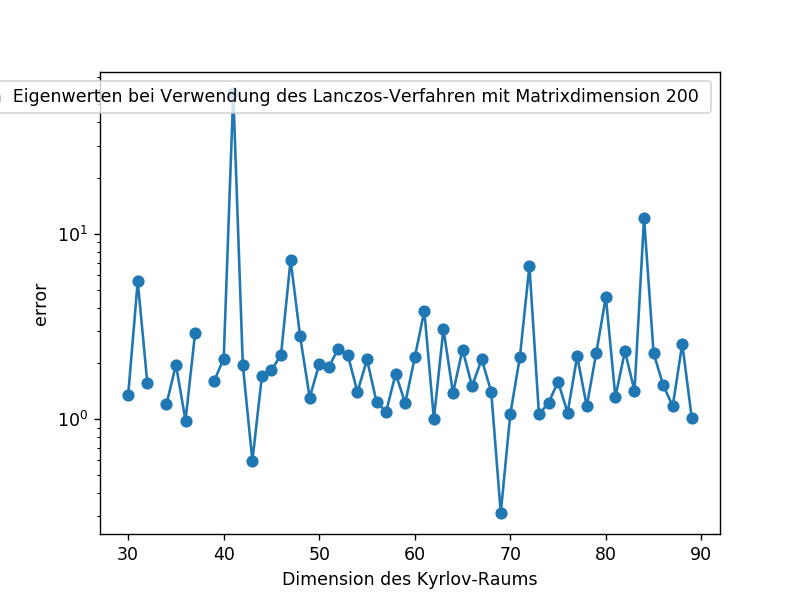

In [60]:
%matplotlib notebook

plt.semilogy(dim_kyrlov, error_lanzcos, '-o', label = "Fehler der {nr} extremalen  Eigenwerten bei Verwendung des Lanczos-Verfahren mit Matrixdimension {dim} ".format(nr = nr_approx_eigs*2, dim = n_dim))
#plt.semilogy(dim_kyrlov, error_lanzcos_1, '-o', label = "Fehler der {nr} extremalen  Eigenwerten bei Verwendung des Lanczos-Verfahren mit Matrixdimension {dim} ".format(nr = nr_approx_eigs*2, dim = n_dim_2))
plt.xlabel("Dimension des Kyrlov-Raums")
plt.ylabel("error")
plt.legend()
plt.show()

Da wir bei dem verallgemeinerten Problem keine Hermitschen Matrizen erhalten, verwenden wir das Arnoldi-Verfahren.

In [ ]:
def arnoldi(A, dim, k = 0):                    #Hier wird die Dimension extra übergeben, da A nicht zwingend eine Matrix sein muss, sondern nur als Funktion übergeben werden kann
    n = dim
    if k == 0:                                 #Falls nicht näher angegeben, werden alle Eigenwerte berechnet
        k = n
        
    v0 = np.random.rand(n)                     #Random-Startvektor wird initialisiert
    v = [v0/np.linalg.norm(v0)]                #Der Vektor wird zusätzlich normiert
    h = np.zeros((k,k))                        #h ist die neue Matrix die erstellt wird, entspricht T aus dem Lanczos-Verfahern
    
    for j in range(k):
        w = A(v[j])                            #Entspricht A@v[j]
        for l in range(j+1):                   #Schleife für Orthogonalisierung nach Gram-Schmidt
            h[l][j] = v[l].T.conj()@w          #Enstpricht v[l]*@w = (v[l], w)
            w = w - h[l][j]*v[l]               #Gram-Schmidt Orthogonalisierung
        if j < k-1:                            #Nur im letzten Druchlauf nicht erfüllt
            h[j+1][j] = np.sqrt(w.T.conj()@w)  #sqrt((w,w)) zur Normierung
            if abs(h[j+1][j]) < 1e-14:         #Invarianter Unterraum gefunden, entspricht delta-Bedingung aus Lanczos
                return QR_hesse(h[:j+1,:j+1])  #Eigenwertberechnung der kleineren Matrix
            else:
                v.append(w/h[j+1][j])          #Normierter Vektor wird hinzugefügt
    
    return QR_hesse(h)

In [ ]:
error_arnoldi = [0]*k
error_arnoldi_1 = [0]*k

for i in range(k):
    error_arnoldi[i] = selective_error(np.array(arnoldi(lambda x: mat_unshifted@x, n_dim, dim_kyrlov[i])[1]), eigvalues, nr_approx_eigs)
    error_arnoldi_1[i] = selective_error(np.array(arnoldi(lambda x: mat_unshifted_1@x, n_dim_2, dim_kyrlov[i])[1]), eigvalues_1, nr_approx_eigs)

In [ ]:
#%matplotlib notebook

plt.semilogy(dim_kyrlov, error_arnoldi, '-o', label = "Fehler im Arnoldi-Verfahrenunter den ersten {nr}  Eigenwerten bei Matrixdimension {dim}".format(nr = nr_approx_eigs*2, dim = n_dim))
plt.semilogy(dim_kyrlov, error_arnoldi, '-o', label = "Fehler im Arnoldi-Verfahrenunter den ersten {nr}  Eigenwerten bei Matrixdimension {dim}".format(nr = nr_approx_eigs*2, dim = n_dim_2))
plt.xlabel("Dimension des Kyrlov-Raums")
plt.ylabel("Error")
plt.legend()
plt.show()

Falls wir nicht an allen Eigenwerten interessiert sind, können wir einige extremale wesentlich Zeiteffizienter berechnen.


In [ ]:
n_arr_3 = [10*i for i in range(5,50)]                                 #Dimension des Problems

k = len(n_arr_3)
eigv_array_3 = []
for i in range(k):
    eigv_array_3.append(np.sort(5000*np.random.rand(n_arr_3[i])-2500)) #Eigenwerte werden zufällig generiert
    
mat_array_3 = []

for i in range(k):
    mat_array_3.append(gen_hermite(eigv_array_3[i]))

In [ ]:
time_arnoldi_2 = [0]*k
error_arnoldi_2 = [0]*k

time_QR_shifts = [0]*k
error_QR_shifts = [0]*k

for i in range(k):
    time_arnoldi_2[i], error_arnoldi_2[i] = runtime_error(arnoldi,mat_array_3[i], eigv_array_3[i], n_arr_3[i], 40)
    time_QR_shifts[i], error_QR_shifts[i] = runtime_error(QR_shift2,mat_array_3[i], eigv_array_3[i])

In [ ]:
#%matplotlib notebook

plt.loglog(n_arr_3, time_arnoldi_2,'-o', label = "Zeit für das Arnoldi-Verfahren beim berechnen von 40 Eigenwerten")
plt.loglog(n_arr_3, time_QR_shifts, '-o', label = "Zeit für das QR-Verfahren mit Shifts")
plt.loglog(n_arr_3, (0.01*np.array(n_arr_3))**3, label = "Vergleichsgerade $n^3$")
plt.xlabel("n")
plt.ylabel("time")

plt.legend()
plt.show()

## Applying the Arnoldi-Iteration to get eigenvalues of $-\Delta$ 

### Setting Ngsolve Parameters

In [ ]:
a = 2              # Length of rectangle in x direction 
b = 1             # Length of rectangle in y direction 
R = 1             # Radius of circle

maxh = 0.05   # Mesh-size
order = 4      # Order of Polynomials
nr_eigs = 200    # Number of Eigenvalues to approximate

### Create rectangle via Netgen

In [ ]:
geo = SplineGeometry()
geo.AddRectangle((0,0), (a,b), bcs=["b","r","t","l"])


mesh = Mesh(geo.GenerateMesh(maxh=maxh))
Draw(mesh)

### FES and the bilinear- and linearform

In [ ]:
fes = H1(mesh, complex=True, order=order)

eigenvec = GridFunction(fes,multidim=nr_eigs)

u = fes.TrialFunction()
v = fes.TestFunction()

a = BilinearForm (fes)
a += SymbolicBFI (grad(u)*grad(v))

b = BilinearForm (fes)
b += SymbolicBFI (u*v)

a.Assemble()
b.Assemble()

A=a.mat
B=b.mat

print(fes.ndof)


### Eigenvalues via scipy

In [ ]:
shift = 3

shifted = a.mat.CreateMatrix()
shifted.AsVector().data = a.mat.AsVector() - (shift**2)*b.mat.AsVector()
invshifted = shifted.Inverse(freedofs=fes.FreeDofs())
print(a.mat.height)
tmp1 = eigenvec.vec.CreateVector()
tmp2 = eigenvec.vec.CreateVector()
def matvec(v):
    tmp1.FV().NumPy()[:] = v
    tmp2.data = b.mat * tmp1
    tmp1.data = invshifted * tmp2
    return tmp1.FV().NumPy()

A = scipy.sparse.linalg.LinearOperator( (a.mat.height,a.mat.width), matvec)
mu, vecs = scipy.sparse.linalg.eigs(A,nr_eigs)

lamsquared=shift**2+1/mu
lamsquared = sorted(lamsquared)
lams=[sqrt(l) for l in lamsquared]
print("resonances:")
for i in range (0,10):
    print(i,": ",lams[i], " squared: ", lamsquared[i])  


### Eigenvalues via arnoldi

In [ ]:
mu = arnoldi(A, a.mat.height, nr_eigs)[1]

for i in range(len(mu)):
    mu[i] = shift**2+1/mu[i]
lamsquared_1 = mu
lamsquared_1 = sorted(lamsquared_1)
lams_1= [sqrt(l) for l in lamsquared_1]
print("resonances:")
for i in range (0,10):
    print(i,": ",lams_1[i], " squared: ", lamsquared_1[i])  


### Calculating the exact eigenvalues

In [ ]:
def exact_eigvals(n,m):
    return np.pi**2*((n**2)/4 + m**2)

exact_arr = []

for n in range(50):
    for m in range(20):
        exact_arr.append(exact_eigvals(n,m))
        
exact_arr = sorted(exact_arr)
exact_arr = exact_arr[:int(nr_eigs*0.45)]

### Plotting the error of the first 44% of eigenvalues

In [ ]:
%matplotlib notebook

for k in range(1,int(nr_eigs*0.45)):
    plt.plot(k,plot_err_1(exact_arr, lamsquared_1,k), 'o')

plt.xlabel("Number of Eigenvalue")
plt.ylabel("Error of the Eigenvalue")
plt.show()